In [6]:
import torch
from torch.utils.data import DataLoader
import os 
import cv2


In [7]:
from torchvision import transforms

def load_images(image_folder):
    images = {}
    for filename in os.listdir(image_folder):
        if filename.endswith('_test.jpg'):
            file_id = filename.split('_')[0]
            full_path = os.path.join(image_folder, filename)
            image = cv2.imread(full_path)  
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
            image_tensor = transforms.ToTensor()(image)  
            images[file_id] = {"image": image_tensor}
    return images

In [8]:
def parse_annotations(annotation_folders):
    annotations = {}
    for file in os.listdir(annotation_folders):
        if file.endswith('.txt'):
            file_id = os.path.splitext(file)[0]
            file_path = os.path.join(annotation_folders, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                bbox_data = []
                labels = []
                for line in lines:
                    x1, y1, x2, y2, damage_type = map(int, line.split())
                    bbox_data.append([x1, y1, x2, y2]) 
                    labels.append(damage_type) 

                bbox_tensor = torch.tensor(bbox_data, dtype=torch.float32) 
                labels_tensor = torch.tensor(labels, dtype=torch.int64)  
                annotations[file_id] = {'boxes': bbox_tensor, 'labels': labels_tensor}
    return annotations

In [9]:
annotations = parse_annotations("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/combined_group/images_not")
dataset_image  = load_images("C:/Users/DARYL/Schoolwork/FYP/Surface-Defect-Detection/DeepPCB/PCBData/combined_group/images")
merged_dict = {img_id: (dataset_image[img_id], annotations[img_id]) for img_id in dataset_image if img_id in annotations}

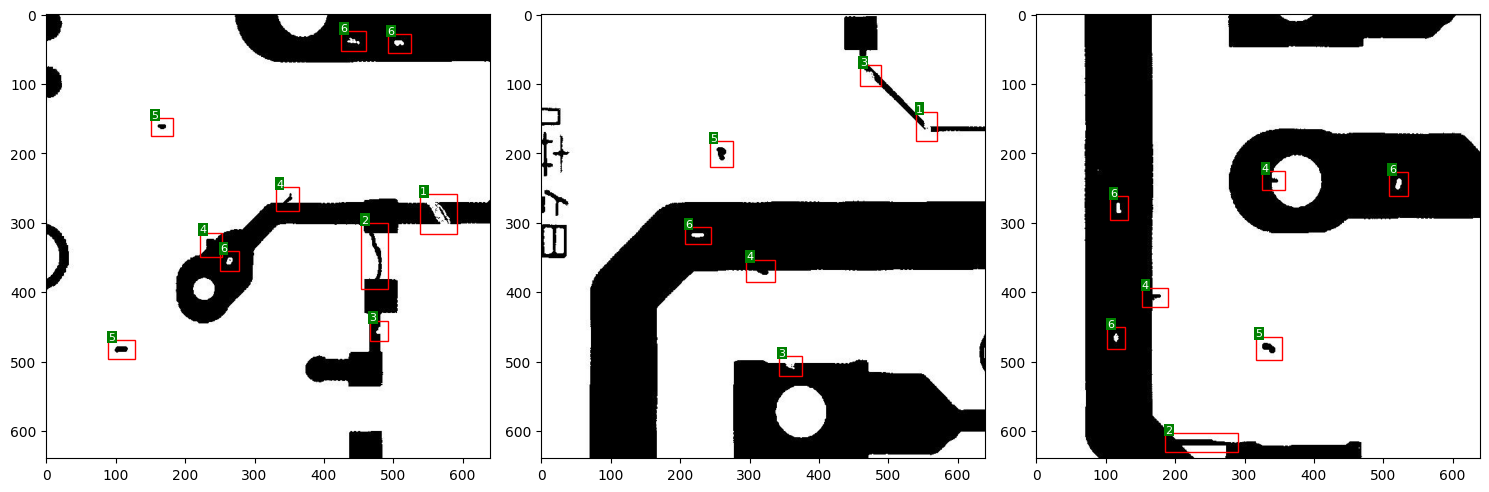

In [18]:
import matplotlib.pyplot as plt
from matplotlib import patches

num_images_to_display = 3

fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))

for i, image_id in enumerate(list(merged_dict.keys())[:num_images_to_display]):
    data_item= merged_dict[image_id]
    image_tensor = data_item[0]["image"]
    annotations = data_item[1]
    boxes = annotations['boxes']
    gt_labels = annotations['labels']  
    image_np = image_tensor.permute(1, 2, 0).numpy()
    
    ax = axs[i]
    ax.imshow(image_np)
    
    for bbox, label in zip(boxes, gt_labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))
    
    ax.axis('on')

plt.tight_layout()
plt.show()


In [12]:
from torch.utils.data import Dataset

class PCBDefectDataset(Dataset):
    def __init__(self, data, transform=None):
        """
        Args:
            data (dict): A dictionary where keys are image IDs and values are tuples,
                         with the first element being the image tensor and the second
                         being the annotation dictionary containing 'boxes' and 'labels'.
            transform (callable, optional): Optional transform to be applied on the image.
        """
        self.data = data
        self.ids = list(data.keys())  
        self.transform = transform 

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        image, targets = self.data[img_id] 
        if self.transform:
            image = self.transform(image)  
        return image, targets


In [13]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset

def collate_fn(batch):
    images, annotations = zip(*batch)
    return list(images), list(annotations) 

from torch.utils.data import DataLoader, random_split

# Assuming PCBDefectDataset is defined and merged_dict is available
dataset = PCBDefectDataset(merged_dict, transform=None)

# Calculate lengths for splits
total_size = len(dataset)
train_size = int(0.7 * total_size)  # 70% of dataset
validate_size = int(0.15 * total_size)  # 15% of dataset
test_size = total_size - train_size - validate_size  # Remaining data for testing

# Split the dataset
train_dataset, validate_dataset, test_dataset = random_split(dataset, [train_size, validate_size, test_size])

batch_s = 4
# Create DataLoader for each subset
train_loader = DataLoader(train_dataset, batch_size=batch_s, shuffle=True, collate_fn=collate_fn)
validate_loader = DataLoader(validate_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)

# test image 
subset_indices = [0,1]
train_subset = Subset(dataset, subset_indices)
train_loader_single = DataLoader(train_subset, batch_size=batch_s, shuffle=False, collate_fn=collate_fn)

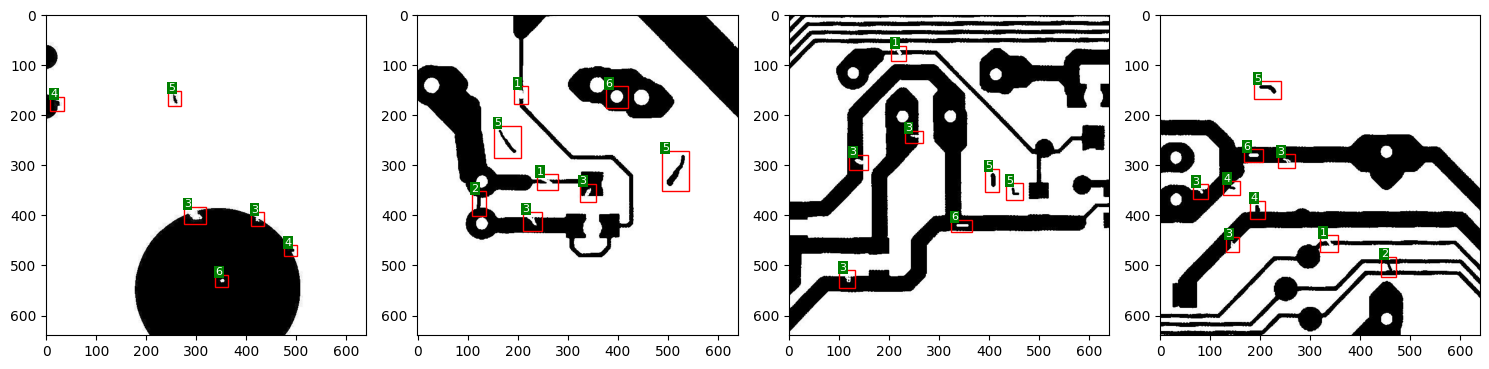

In [15]:
num_images_to_display = 4
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 5))
for i in range(num_images_to_display):
    data_item = train_dataset[i]
    image_tensor = data_item[0]["image"]
    annotations = data_item[1]
    boxes = annotations['boxes']
    gt_labels = annotations['labels']  
    image_np = image_tensor.permute(1, 2, 0).numpy()
    ax = axs[i]
    ax.imshow(image_np) 
    for bbox, label in zip(boxes, gt_labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))
    ax.axis('on')
plt.tight_layout()
plt.show()

In [16]:
import torchvision
from torchvision.models.detection.faster_rcnn import FasterRCNN_ResNet50_FPN_Weights, FastRCNNPredictor

weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights)

in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 7  # 6 object classes + 1 background

model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


In [13]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [14]:
print(torch.version.cuda)
if torch.cuda.is_available():
    print("CUDA is available. Device name:", torch.cuda.get_device_name(0))
else:
    print("CUDA is not available.")


12.1
CUDA is available. Device name: NVIDIA GeForce RTX 3080 Ti


In [41]:
from torch.optim import SGD

train_losses_list = []
validate_losses_list =[]
all_outputs = []

num_epochs = 100
params = [p for p in model.parameters() if p.requires_grad]
optimizer = SGD(params, lr=1e-5, momentum=0.9, weight_decay=1e-6)
model.to(device)
n_images = 400

print("num epochs",num_epochs)
print("num images",n_images)
for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    images_processed = 0
    for data in train_loader:
        # if images_processed >= n_images:
        #     break
        imgs = data[0]
        targets = data[1]
        imgs = [img.to(device) for img in imgs]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(imgs, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_train_loss += losses.item()
        images_processed += len(imgs)
    
    avg_train_loss = epoch_train_loss / len(train_dataset.dataset)
    train_losses_list.append(avg_train_loss)
    print(images_processed)
    print(f"Epoch {epoch}: Average Training Loss: {avg_train_loss}")

    # Validation phase
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for imgs, targets in validate_loader:
            imgs = [img.to(device) for img in imgs]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(imgs)

            model.train()
            loss_dict = model(imgs, targets)
            model.eval() 
            
            losses = sum(loss for loss in loss_dict.values())
            epoch_val_loss += losses.item()
            all_outputs.extend(outputs)
    avg_val_loss = epoch_val_loss / len(validate_loader.dataset)
    validate_losses_list.append(avg_val_loss)
    print(f"Epoch {epoch}: Average Validation Loss: {avg_val_loss}")



num epochs 100
num images 400
704
Epoch 0: Average Training Loss: 0.2544132460419748
Epoch 0: Average Validation Loss: 0.245981019337972
704
Epoch 1: Average Training Loss: 0.18050817769043015
Epoch 1: Average Validation Loss: 0.2808791454633077
704
Epoch 2: Average Training Loss: 0.1989530393664927
Epoch 2: Average Validation Loss: 0.3026548397541046
704
Epoch 3: Average Training Loss: 0.20824809262814153
Epoch 3: Average Validation Loss: 0.3087342902024587
704
Epoch 4: Average Training Loss: 0.2129695506740517
Epoch 4: Average Validation Loss: 0.31692253629366557
704
Epoch 5: Average Training Loss: 0.21814633316358562
Epoch 5: Average Validation Loss: 0.3226334643363953
704
Epoch 6: Average Training Loss: 0.22121301998437992
Epoch 6: Average Validation Loss: 0.32751998980840047
704
Epoch 7: Average Training Loss: 0.22454271769191825
Epoch 7: Average Validation Loss: 0.333138477007548
704
Epoch 8: Average Training Loss: 0.227257042234508
Epoch 8: Average Validation Loss: 0.33661881685

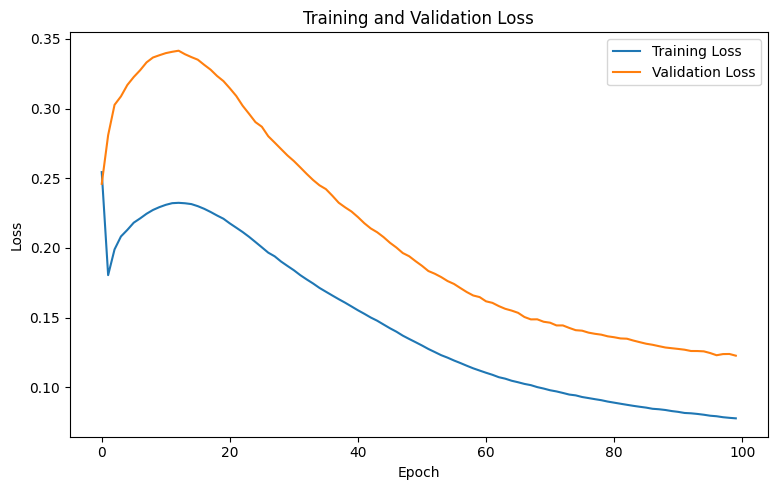

In [42]:
plt.figure(figsize=(15, 5))

# Plot 1: Losses
plt.subplot(1, 2, 1)
plt.plot(train_losses_list, label='Training Loss')
plt.plot(validate_losses_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [107]:
from torchvision.ops import nms

nms_outputs = []
for output in all_outputs:  
    boxes = output['boxes']
    scores = output['scores']
    labels = output['labels']
    print("out_bbox",boxes.shape)

    keep = nms(boxes, scores, 0.50)  


    nms_outputs.append({
        'boxes': boxes[keep],
        'labels': labels[keep],
        'scores': scores[keep]
    })
    print("keep",boxes[keep].shape)


out_bbox torch.Size([100, 4])
keep torch.Size([58, 4])
out_bbox torch.Size([91, 4])
keep torch.Size([47, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([75, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([56, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([69, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([43, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([50, 4])
out_bbox torch.Size([9, 4])
keep torch.Size([8, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([52, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([55, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([51, 4])
out_bbox torch.Size([99, 4])
keep torch.Size([52, 4])
out_bbox torch.Size([31, 4])
keep torch.Size([25, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([62, 4])
out_bbox torch.Size([85, 4])
keep torch.Size([34, 4])
out_bbox torch.Size([100, 4])
keep torch.Size([56, 4])
out_bbox torch.Size([82, 4])
keep torch.Size([35, 4])
out_bbox torch.Size([88, 4])
keep torch.Size([35, 4])
out_bbox torch.Size

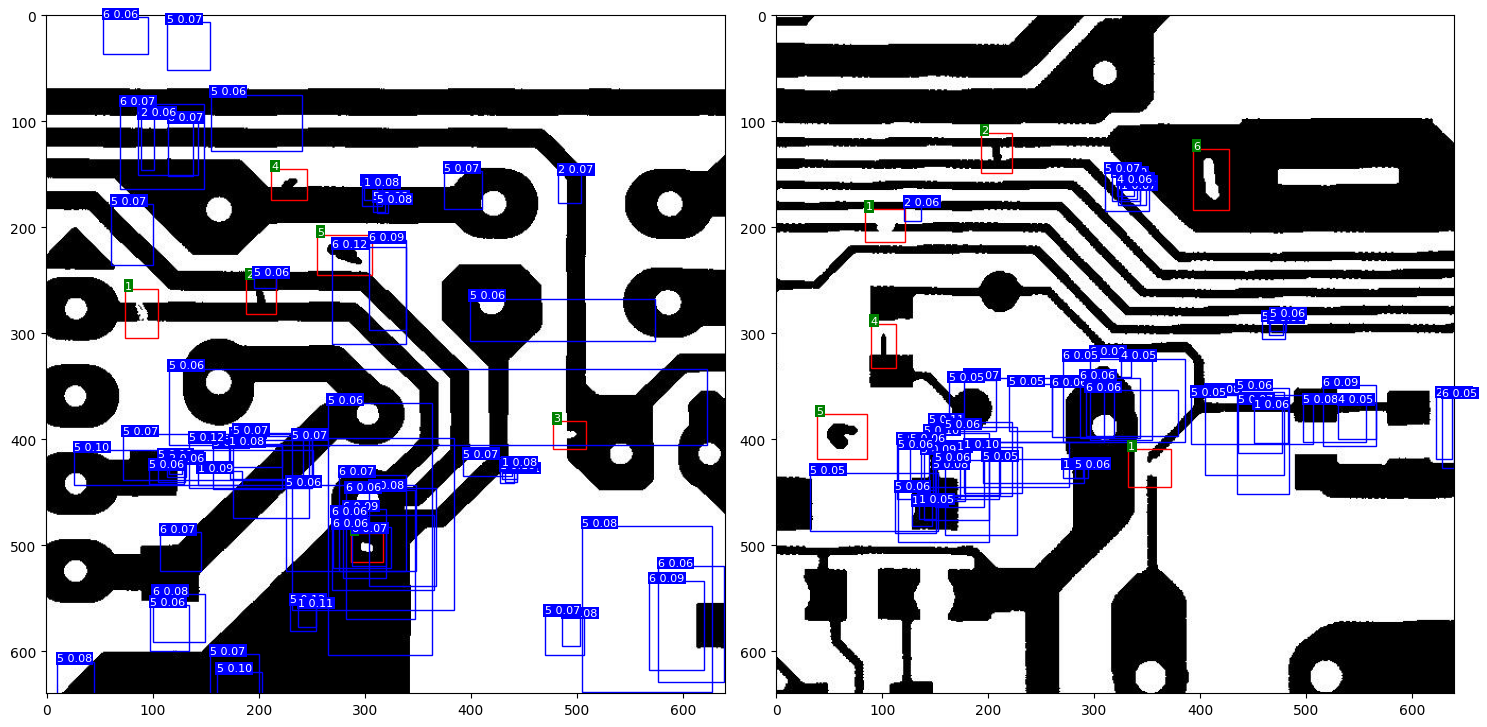

In [108]:
num_images_to_display = 2
fig, axs = plt.subplots(1, num_images_to_display, figsize=(15, 15))
for i in range(num_images_to_display):
    data_item = validate_dataset[i]
    image_tensor = data_item[0]["iamge"]
    annotations = data_item[1]
    boxes = annotations['boxes']
    gt_labels = annotations['labels']  
    image_np = image_tensor.permute(1, 2, 0).numpy()
    ax = axs[i]
    ax.imshow(image_np) 
    for bbox, label in zip(boxes, gt_labels):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, str(label.item()), color='white', fontsize=8, 
                bbox=dict(facecolor='green', edgecolor='none', pad=1))
    output = nms_outputs[i]
    nms_boxes = output['boxes'].cpu()
    nms_labels = output['labels'].cpu()
    nms_scores = output['scores'].cpu()
    for bbox, label, score in zip(nms_boxes, nms_labels, nms_scores):
        xmin, ymin, xmax, ymax = bbox
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, linewidth=1, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)
        ax.text(xmin, ymin, f'{label.item()} {score:.2f}', color='white', fontsize=8, 
                bbox=dict(facecolor='blue', edgecolor='none', pad=1))
    ax.axis('on')
plt.tight_layout()
plt.show()